# 斑点检测
在计算机视觉中，斑点检测是指在数字图像中找出和周围区域特性不同的区域，这些特性包括光照或颜色等。一般图像中斑点区域的像素特性相似甚至相同，某种程度而言，斑点块中所有点是相似的。如果将兴趣点的特性形式化表达为像素位置的函数，那么主要有两类斑点检测方法:
- 差分方法。这类方法主要基于函数在对应像素点处的导数。
- 局部极值方法。这类方法主要是在找出函数的局部极值。

在该领域中，斑点检测也被称为兴趣点检测或者兴趣区域检测。研究斑点检测的目的有几点。其中最主要的是斑点检测能够完整的刻画像素所在区域信息，而这些信息是边缘检测和焦点检测所不能获得的。斑点检测获得的局部区域特征可以被用于后续进一步处理，比如在目标出现和部分遮挡的目标识别或追踪问题中准确刻画目标信息等。在其他领域，斑点检测还可以通过对直方图的尖峰检测实现分割。斑点检测子的另一个常见的应用是作为文本分析和识别中的基元。最新研究中，斑点检测越来越多的被应作图像宽基线立体匹配中的兴趣点检测和基于表观的目标识别中的局部图像特征。

斑点通常是指与周围有着颜色和灰度差别的区域。在实际地图中，往往存在着大量这样的斑点，如一颗树是一个斑点，一块草地是一个斑点，一栋房子也可以是一个斑点。由于斑点代表的是一个区域，相比单纯的角点，它的稳定性要好，抗噪声能力要强，所以它在图像配准上扮演了很重要的角色。同时有时图像中的斑点也是我们关心的区域，比如在医学与生物领域，我们需要从一些X光照片或细胞显微照片中提取一些具有特殊意义的斑点的位置或数量。比如下图中天空的飞机、向日葵的花盘、X线断层图像中的两个斑点

对于边缘检测，我们寻找的是二阶导数的零点，对于斑点检测，我们寻找的是二阶导数的极值点，具体的方法有LoG、DoG、DoH

#1 LoG


##1.1 概述
对于阶跃信号，其二阶导数在对应跃变得位置会产生一个波，该波的过零点正对应着待检测的边缘位置![images](images/12/13.png)而所谓的斑点区域就是两条边形成的中间区域![images](images/12/25.png)这个示意图中上一行从左到右表示的是原始矩形脉冲信号，脉冲信号的周期越来越短，而下一行则表示对应周期在相同尺度下的LoG结果。可以发现总的LoG曲线其实是两条边界上产生的LoG函数的叠加，当两条边界足够小时，在该尺度脉冲下就被作为了blob，这时候LoG曲线的极值就对应着blob的中心。所以边缘检测对应的是LoG的过零点，而斑点检测对应的是LoG的极值点。这里我们可以发现判断是不是blob时，尺度非常重要，只有尺度大于一定值得时候blob才可以通过LoG的极值判定。

可以发现随着尺度的不断增大，LoG曲线由双波谷逐渐融合成单波谷，但是响应的幅值越来越弱。这是因为，随着尺度的增大，LoG算子的最大幅度逐渐减小，导致响应也随着尺度的增大而减小。这种情况我们没法知道选定的尺度是否合适，进而不知道这个尺度下找到的极值点是不是对应着blob的中心点，万一是边缘产生波的极值点怎么办！所以我们这时候应该对LoG算子进行尺度的归一化，所谓尺度归一化，就是不叫结果跟随$\sigma$的变化而变化

具体说明如下，下图是一维信号中大小不同的斑点![images](images/12/26.png)下图是高斯函数的二阶导数，也就是LoG算子与上述四个信号的卷积的结果![images](images/12/27.png)，其中$\sigma=1$，我们发现只有右下角的图，很好的检测出了斑点的中心，并且发现斑点的尺寸只好是$\sigma$的二倍，但是LoG只能检测出小斑点，不能检测出像其它三个图上的大斑点，即便增大$\sigma$的值也不行，因为增大了$\sigma$的值，发现图像的极值点开始衰减了，如下程序


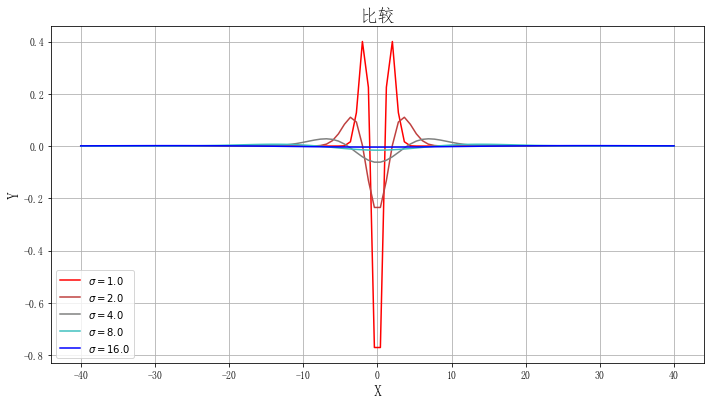

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
x = np.linspace(-40, 40, 100)
sigma = [1,2,4,8, 16]
clrs = []  # 颜色
for c in np.linspace(16711680, 255, 5):
    clrs.append("#{:06X}".format(int(c), 2))
    
plt.figure(figsize=(10, 6), facecolor='w')
for index, cc in enumerate(sigma):
    y = (x**2 - cc**2) / (cc**4) * np.exp(-x**2 / (2 * cc**2))
    title = u'$\sigma=%.1f$' % (cc)
    plt.plot(x, y, color=clrs[index], label=title)

plt.legend(loc='lower left')
plt.grid(True)
plt.title('比较', fontsize=18)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)

plt.tight_layout(1, rect=(0, 0, 1, 0.95))
plt.show()

##1.2 尺度归一化
需要乘以一个$\sigma^2$，这样就如下图所示，这样增大$\sigma$之后，也是可以找到斑点的，斑点的中心就是尺度归一化之后的极值点位置，对于归一化求导，可以得到斑点的半径就是$r=\sqrt{2}\sigma$

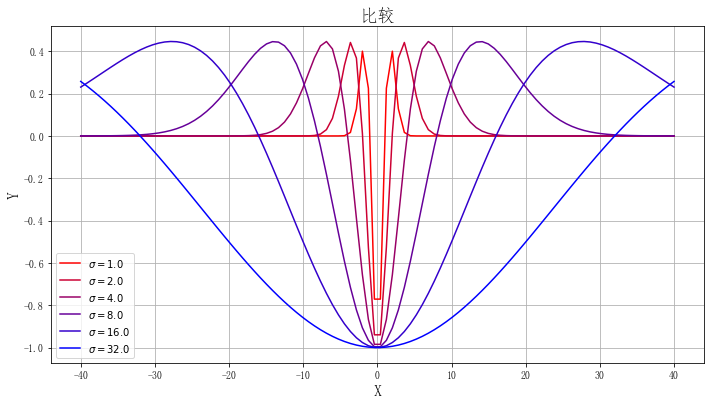

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
x = np.linspace(-40, 40, 100)
sigma = [1,2,4,8, 16,32]
clrs = []  # 颜色
for c in np.linspace(16711680, 255, 6):
    clrs.append("#{:06X}".format(int(c), 2))

plt.figure(figsize=(10, 6), facecolor='w')
for index, cc in enumerate(sigma):
    y = (x**2 - cc**2) / (cc**2) * np.exp(-x**2 / (2 * cc**2))
    title = u'$\sigma=%.1f$' % (cc)
    plt.plot(x, y, color=clrs[index], label=title)

plt.legend(loc='lower left')
plt.grid(True)
plt.title('比较', fontsize=18)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)

plt.tight_layout(1, rect=(0, 0, 1, 0.95))
plt.show()

##1.3 步骤
1. 得到图像的灰度图像
2. 生成若干个sigma，可以根据linspace或者logspace来生成
3. 用生成的sigma，对灰度图像做LoG操作，然后进行尺度归一化(乘以$\sigma^2$),得到若干个LoG之后的图像数组
4. 对于每一个图像数组找到其中的极大值的位置
5. 去掉重复的位置
6. 最后的结果包括三个元素，x点坐标，y点坐标，半径，这个半径在画图的时候需要乘以$\sqrt{2}$


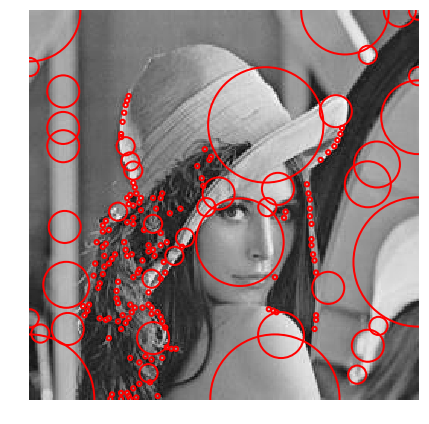

In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage.util as sku
import skimage.feature as skf
import scipy.ndimage as sn
import itertools as itt
import math
def _blob_overlap(blob1, blob2):
    root2 = np.sqrt(2)

    r1 = blob1[2] * root2 #blob1的半径
    r2 = blob2[2] * root2 #blob2的半径

    d = np.hypot(blob1[0] - blob2[0], blob1[1] - blob2[1]) #计算两个中心点的欧氏距离

    if d > r1 + r2: #如果两个圆根本没交点
        return 0

    if d <= abs(r1 - r2): #如果其中一个圆在另一个圆的内部
        return 1

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = np.arccos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = np.arccos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * np.sqrt(abs(a * b * c * d))

    return area / (math.pi * (min(r1, r2) ** 2))

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
image_gray = cv2.imread('images/12/Lena.png', cv2.IMREAD_GRAYSCALE)
image_gray = sku.img_as_float(image_gray)
sigma_list = np.linspace(1, 30, 10)
gl_images = [-sn.gaussian_laplace(image, s) * s ** 2 for s in sigma_list]

local_maxima = skf.peak_local_max(image_cube, threshold_abs=0.1,
                              footprint=np.ones((3, 3, 3)),
                              threshold_rel=0.0,
                              exclude_border=False)

lm = local_maxima.astype(np.float64)
lm[:, 2] = sigma_list[local_maxima[:, 2]]
local_maxima = lm

for blob1, blob2 in itt.combinations(local_maxima, 2):
    if _blob_overlap(blob1, blob2) > 0.5:
        if blob1[2] > blob2[2]:
            blob2[2] = -1
        else:
            blob1[2] = -1

result = np.array([b for b in local_maxima if b[2] > 0])
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image_gray, cmap='gray', interpolation='nearest')

for blob in result:
    y, x, r = blob
    c = plt.Circle((x, y), r * np.sqrt(2), color='r', linewidth=2, fill=False)
    ax.add_patch(c)
ax.set_axis_off()
plt.tight_layout()
plt.show()

#2 DoG检测
DoG就是两个高斯函数的插值，LoG可以近似的用DoG来表示。因为LOG滤波器有无限长的拖尾，若取得很大尺寸，将使得计算不堪重负，所以DoG的计算量要小于LoG,$DoG=G(x,y,k\sigma) − G(x,y,\sigma) \approx (k − 1)\sigma^2\nabla^2G$，所以DoG是$\sigma^2\nabla^2G$的近似。它有以下优点：
- $\sigma^2\nabla^2G$需要使用两个方向的高斯二阶微分卷积核，而DoG直接使用高斯卷积核，省去了对卷积核的生成的运算量。
- DoG保留了各个高斯尺度空间的图像，这样，在生成某一空间尺度的特征时，可以直接尺度空间图像，而无需重新再次生成该尺度的图像。

